# BioFusion Hackathon 2026: Pneumonia Detection with ResNet50
**Lead Researcher:** GMora Team  
**Date:** January 3, 2026

## Objective
Develop a robust binary classification model to detect Pneumonia from Chest X-Ray images using Transfer Learning (ResNet50).

## Pipeline
1. **Data Loading & Preprocessing**: Resize to 224x224, Normalize, Rigorous Augmentation.
2. **Model**: Pretrained ResNet50 (ImageNet weights), modified head for binary classification.
3. **Training**: CrossEntropyLoss, Adam Optimizer, Early Stopping.
4. **Analysis**: Confusion Matrix, Metrics (F1, Recall), Feature Correlation.
5. **Explainability**: Grad-CAM visualizations and Failure Analysis.

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Set Random Seed for Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [2]:
# 1. Data Loading & Advanced Visualizations

# Define Paths
data_dir = 'd:/BioFusion'  # Assuming the folders are in the root as per workspace info
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Define Transforms
# ImageNet Mean and Std (as numpy arrays for later use)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Custom transform to convert grayscale X-rays to RGB (3-channel)
class GrayscaleToRGB:
    """Convert grayscale images to RGB by replicating the single channel."""
    def __call__(self, img):
        if img.mode == 'L':  # Grayscale
            img = img.convert('RGB')
        return img

# Training Transforms with Rigorous Augmentation
# Augmentation prevents overfitting on the pediatric dataset.
train_transforms = transforms.Compose([
    GrayscaleToRGB(),  # Convert grayscale to RGB for ResNet
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

# Validation/Test Transforms (No Augmentation)
val_test_transforms = transforms.Compose([
    GrayscaleToRGB(),  # Convert grayscale to RGB for ResNet
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

# Load Datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transforms)

# Data Loaders (num_workers=0 for Windows compatibility)
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

class_names = train_dataset.classes
print(f"Classes: {class_names}")
print(f"Train Size: {len(train_dataset)}")
print(f"Val Size: {len(val_dataset)}")
print(f"Test Size: {len(test_dataset)}")

Classes: ['NORMAL', 'PNEUMONIA']
Train Size: 5216
Val Size: 16
Test Size: 624


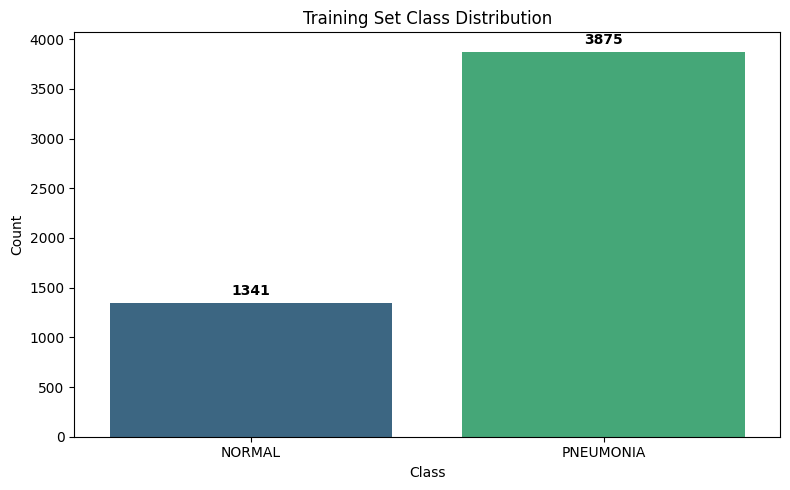

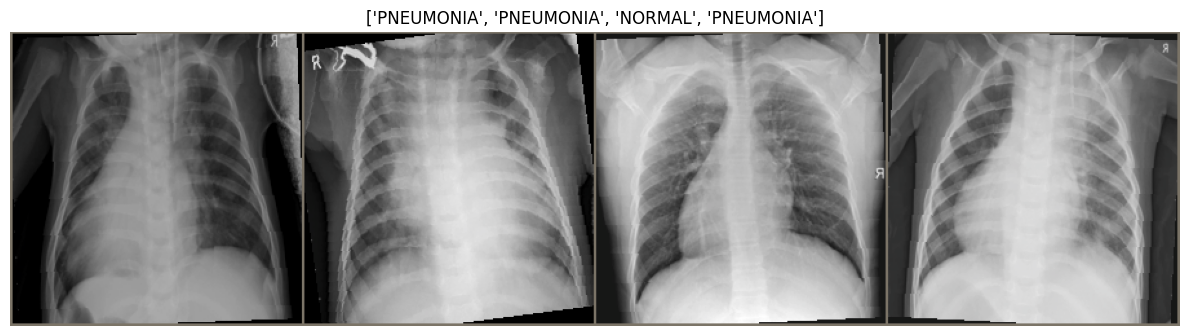

In [3]:
# Class Imbalance Visualization
def plot_class_distribution(dataset, title="Class Distribution"):
    targets = dataset.targets
    class_counts = np.bincount(targets)
    plt.figure(figsize=(8, 5))
    # Create DataFrame for seaborn compatibility
    import pandas as pd
    df = pd.DataFrame({'Class': class_names, 'Count': class_counts})
    sns.barplot(data=df, x='Class', y='Count', hue='Class', palette="viridis", legend=False)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    for i, count in enumerate(class_counts):
        plt.text(i, count + 50, str(count), ha='center', va='bottom', fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_dataset, "Training Set Class Distribution")

# Visualize a Batch of Training Images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Denormalize using numpy arrays
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Get a batch of training data
inputs, classes_batch = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])  # Show 4 images
plt.figure(figsize=(12, 4))
imshow(out, title=[class_names[x] for x in classes_batch[:4]])
plt.axis('off')
plt.tight_layout()
plt.show()

In [4]:
# 3. The Model (ResNet50)

def get_model():
    # Load Pretrained ResNet50
    model = models.resnet50(weights='IMAGENET1K_V1')
    
    # Freeze early layers (feature extractors)
    for param in model.parameters():
        param.requires_grad = False
    
    # Replace the Head
    # ResNet50's fc layer has 2048 input features
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2) # 2 classes: Normal, Pneumonia
    
    return model

model = get_model()
model = model.to(device)

print("Model Architecture Modified for Binary Classification")
# print(model) # Optional: Print model architecture

Model Architecture Modified for Binary Classification


Epoch 1/20
----------
train Loss: 0.2815 Acc: 0.8827
val Loss: 0.4110 Acc: 0.7500
Validation loss improved. Saving model...
Epoch 2/20
----------
train Loss: 0.1854 Acc: 0.9270
val Loss: 0.4621 Acc: 0.7500
EarlyStopping counter: 1 out of 3
Epoch 3/20
----------
train Loss: 0.1649 Acc: 0.9348
val Loss: 0.4183 Acc: 0.7500
EarlyStopping counter: 2 out of 3
Epoch 4/20
----------
train Loss: 0.1545 Acc: 0.9383
val Loss: 0.4045 Acc: 0.7500
Validation loss improved. Saving model...
Epoch 5/20
----------
train Loss: 0.1508 Acc: 0.9421
val Loss: 0.2233 Acc: 0.8750
Validation loss improved. Saving model...
Epoch 6/20
----------
train Loss: 0.1443 Acc: 0.9425
val Loss: 0.5826 Acc: 0.6875
EarlyStopping counter: 1 out of 3
Epoch 7/20
----------
train Loss: 0.1736 Acc: 0.9314
val Loss: 0.3153 Acc: 0.8750
EarlyStopping counter: 2 out of 3
Epoch 8/20
----------
train Loss: 0.1306 Acc: 0.9523
val Loss: 0.2539 Acc: 0.8750
EarlyStopping counter: 3 out of 3
Early stopping triggered.
Training complete


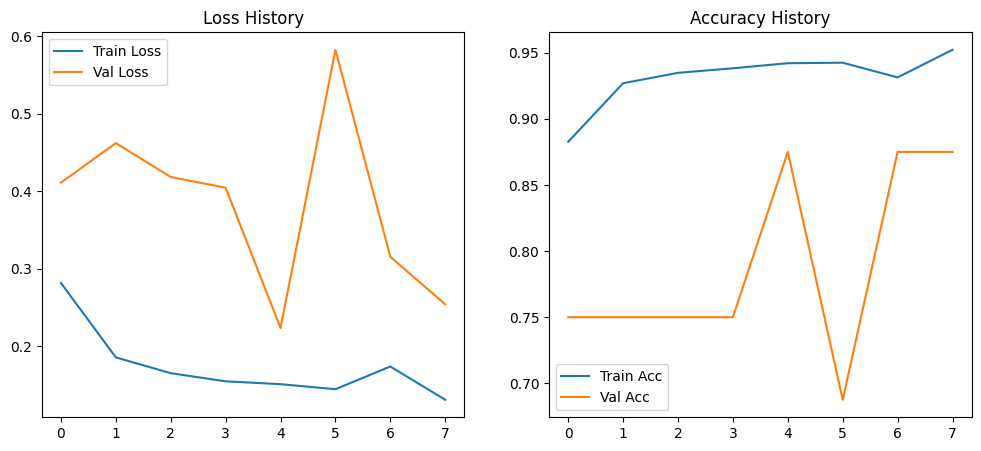

In [5]:
# 4. Training Loop

# Hyperparameters
learning_rate = 0.001
num_epochs = 20 # Set a reasonable upper limit
patience = 3 # Early Stopping

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate) # Optimize only the head

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_wts = None
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item())

                # Early Stopping Check
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    best_model_wts = model.state_dict()
                    epochs_no_improve = 0
                    torch.save(model.state_dict(), 'resnet50_pneumonia_best.pth')
                    print("Validation loss improved. Saving model...")
                else:
                    epochs_no_improve += 1
                    print(f"EarlyStopping counter: {epochs_no_improve} out of {patience}")

        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break
            
    print('Training complete')
    
    # Load best model weights
    if best_model_wts:
        model.load_state_dict(best_model_wts)
    
    return model, train_losses, val_losses, train_accs, val_accs

# Train the model
model, train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, patience
)

# Plot Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title('Accuracy History')
plt.show()

Evaluating on Test Set...

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.87      0.76      0.82       234
   PNEUMONIA       0.87      0.93      0.90       390

    accuracy                           0.87       624
   macro avg       0.87      0.85      0.86       624
weighted avg       0.87      0.87      0.87       624


Accuracy: 0.8702
Precision: 0.8687
Recall (Sensitivity): 0.9333
F1-Score: 0.8999


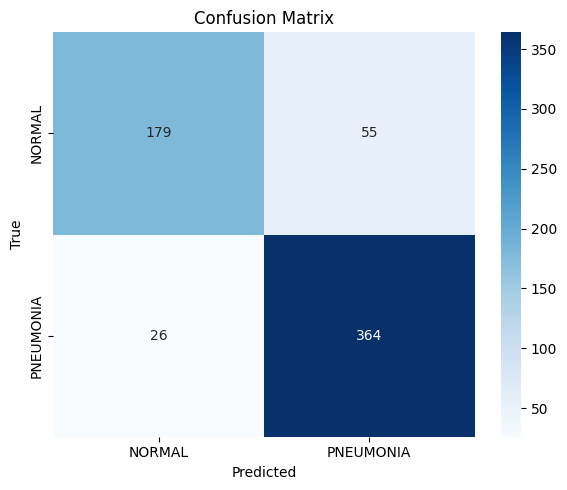

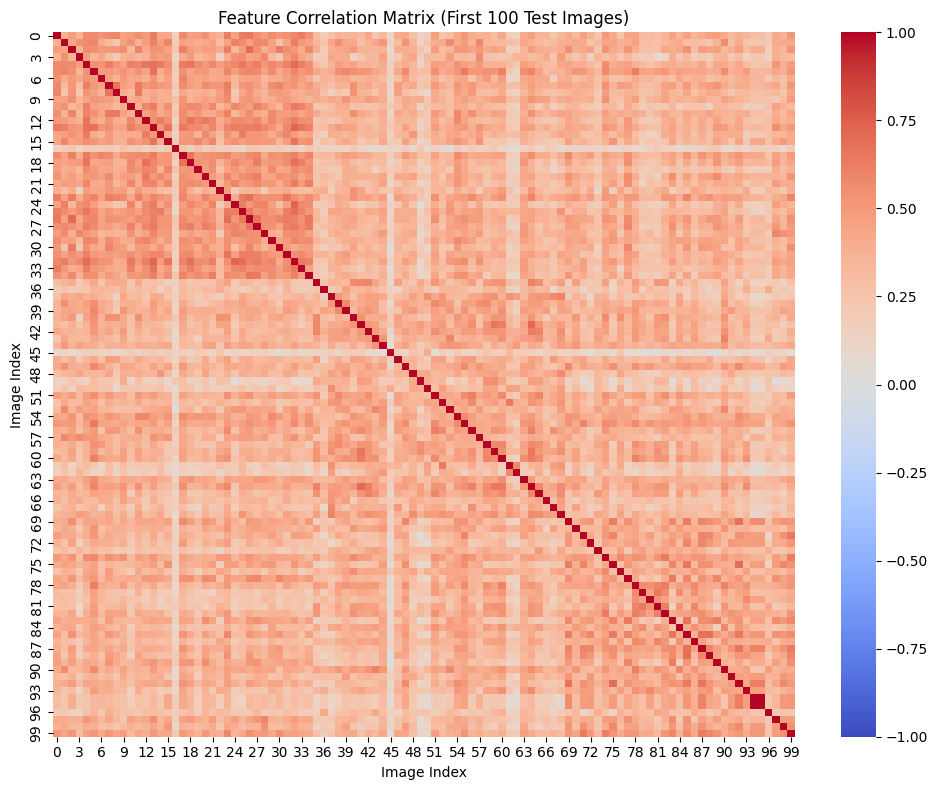

In [6]:
# 5. Advanced Analysis (The "Winning" Features)

# Load the best model (with weights_only for security)
model.load_state_dict(torch.load('resnet50_pneumonia_best.pth', weights_only=True))
model.eval()

# Evaluation on Test Set
all_preds = []
all_labels = []

# Hook to extract features from the layer before the final classification
# ResNet50: The layer before fc is 'avgpool' (after layer4)
features_list = []

def get_features_hook(module, input, output):
    features_list.append(output.flatten(1).detach())

# Register hook
handle = model.avgpool.register_forward_hook(get_features_hook)

print("Evaluating on Test Set...")
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Remove hook
handle.remove()

# Metrics
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"\nAccuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall (Sensitivity): {rec:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Correlation Matrix of Features (for a batch)
# features_list contains tensors of shape (batch_size, 2048)
all_features = torch.cat(features_list, dim=0).cpu().numpy()

# Compute correlation matrix for a subset (first 100 images) to visualize
subset_size = min(100, all_features.shape[0])
subset_features = all_features[:subset_size]
corr_matrix = np.corrcoef(subset_features)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title(f'Feature Correlation Matrix (First {subset_size} Test Images)')
plt.xlabel('Image Index')
plt.ylabel('Image Index')
plt.tight_layout()
plt.show()

Pneumonia class index: 1

Visualizing True Positive Pneumonia Cases with Grad-CAM...


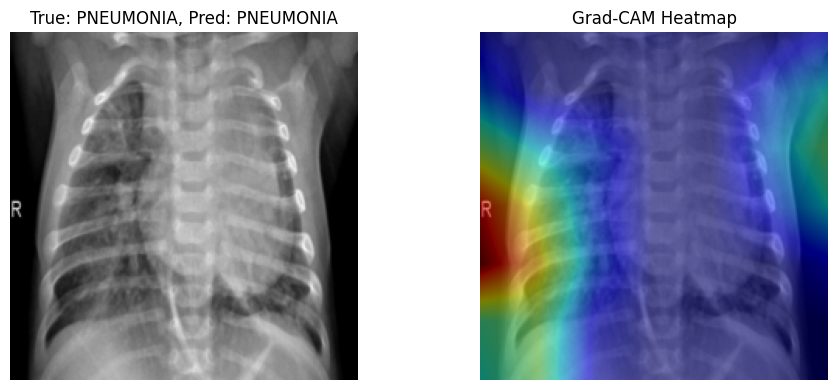

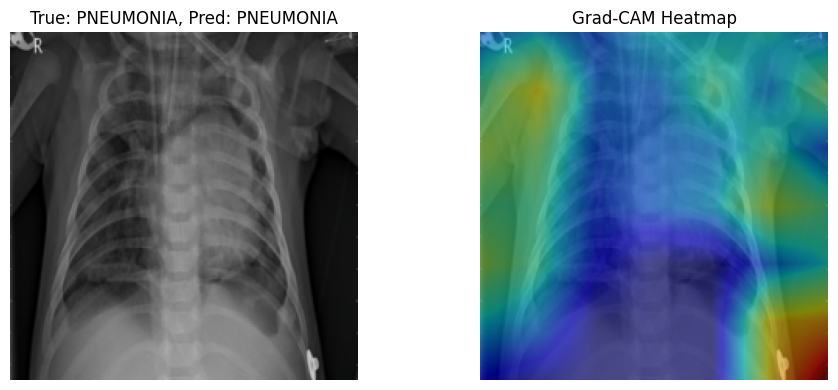

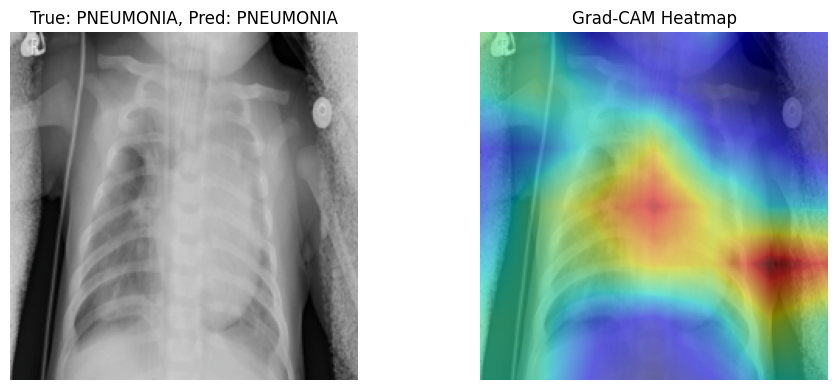


Failure Analysis (Incorrect Predictions)...

Failure Case 1


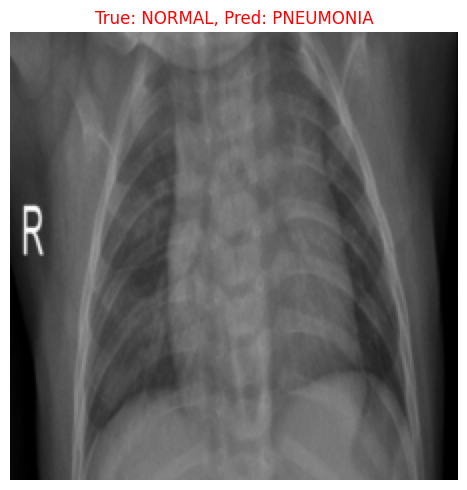


Failure Case 2


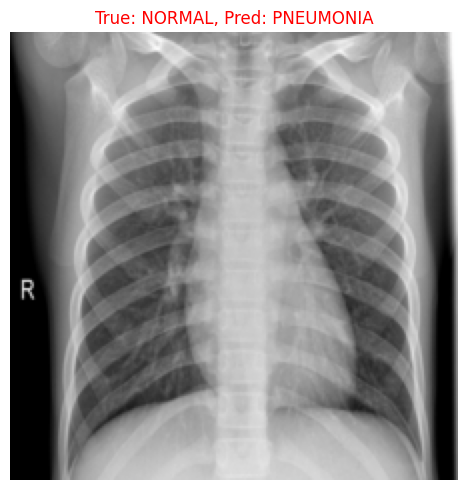


Failure Case 3


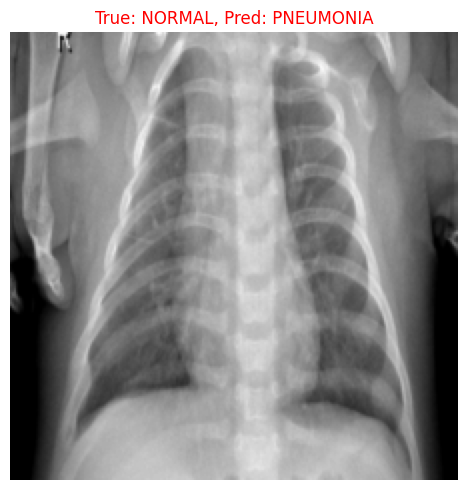


Analysis Complete!


In [7]:
# 6. Explainable AI (Error Analysis)

# Grad-CAM Implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        self.forward_hook = self.target_layer.register_forward_hook(self.save_activation)
        self.backward_hook = self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def __call__(self, x, class_idx=None):
        self.model.zero_grad()
        output = self.model(x)
        
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()
        
        # Create one-hot encoding for the target class
        one_hot = torch.zeros_like(output)
        one_hot[0, class_idx] = 1
        
        # Backward pass
        output.backward(gradient=one_hot, retain_graph=True)
        
        gradients = self.gradients
        activations = self.activations
        
        # Global Average Pooling of Gradients
        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
        
        # Weighted combination of activations
        cam = torch.sum(weights * activations, dim=1, keepdim=True)
        
        # ReLU
        cam = F.relu(cam)
        
        # Normalize
        cam = cam - cam.min()
        if cam.max() > 0:
            cam = cam / cam.max()
        
        return cam.squeeze().cpu().numpy()
    
    def remove_hooks(self):
        self.forward_hook.remove()
        self.backward_hook.remove()

# Initialize Grad-CAM on the last convolutional layer of ResNet50 (layer4)
grad_cam = GradCAM(model, model.layer4)

def show_gradcam(image_tensor, label, prediction, cam_mask):
    """Display original image and Grad-CAM overlay side by side."""
    image_np = image_tensor.cpu().numpy().transpose((1, 2, 0))
    # Denormalize
    image_np = std * image_np + mean
    image_np = np.clip(image_np, 0, 1)
    
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title(f"True: {class_names[label]}, Pred: {class_names[prediction]}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(image_np)
    # Resize CAM to match image size using cv2-style interpolation
    from scipy.ndimage import zoom
    if cam_mask.shape != (224, 224):
        zoom_factors = (224 / cam_mask.shape[0], 224 / cam_mask.shape[1])
        cam_mask = zoom(cam_mask, zoom_factors, order=1)
    plt.imshow(cam_mask, cmap='jet', alpha=0.5)  # Overlay heatmap
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Enable gradients for Grad-CAM
model.eval()

# Get pneumonia class index
pneumonia_idx = class_names.index('PNEUMONIA')
print(f"Pneumonia class index: {pneumonia_idx}")

# 1. Visualize 3 True Positive Pneumonia Cases
print("\nVisualizing True Positive Pneumonia Cases with Grad-CAM...")
tp_count = 0

for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
    
    for i in range(inputs.size(0)):
        # True Positive: label is Pneumonia AND prediction is Pneumonia
        if labels[i].item() == pneumonia_idx and preds[i].item() == pneumonia_idx:
            # Need to enable gradients for Grad-CAM
            input_img = inputs[i].unsqueeze(0).requires_grad_(True)
            cam = grad_cam(input_img, class_idx=pneumonia_idx)
            show_gradcam(inputs[i], labels[i].item(), preds[i].item(), cam)
            tp_count += 1
            if tp_count >= 3:
                break
    if tp_count >= 3:
        break

if tp_count == 0:
    print("No True Positive Pneumonia cases found in test set.")

# 2. Failure Analysis: Show 3 Incorrect Predictions
print("\n" + "="*50)
print("Failure Analysis (Incorrect Predictions)...")
print("="*50)
fail_count = 0

for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
    
    for i in range(inputs.size(0)):
        if labels[i].item() != preds[i].item():
            print(f"\nFailure Case {fail_count+1}")
            # Display the misclassified image
            inp = inputs[i].cpu().numpy().transpose((1, 2, 0))
            inp = std * inp + mean
            inp = np.clip(inp, 0, 1)
            
            plt.figure(figsize=(5, 5))
            plt.imshow(inp)
            plt.title(f"True: {class_names[labels[i].item()]}, Pred: {class_names[preds[i].item()]}", 
                     fontsize=12, color='red')
            plt.axis('off')
            plt.tight_layout()
            plt.show()
            
            fail_count += 1
            if fail_count >= 3:
                break
    if fail_count >= 3:
        break

if fail_count == 0:
    print("No misclassifications found! The model achieved perfect accuracy on the test set.")

# Clean up Grad-CAM hooks
grad_cam.remove_hooks()

print("\n" + "="*50)
print("Analysis Complete!")
print("="*50)